# Beat detection
Beat detection and feature extraction from sound files
using librosa and mel-spectograms.

Runs best in browser notebook mode.

In [1]:
%matplotlib inline
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display, Image, YouTubeVideo


In [2]:
from os import listdir
from os.path import isfile, join, abspath
import re
filenames = [f for f in listdir('.\sounds') if isfile(join('.\sounds', f))][1:]
#Check for legit files and print out the files
print(filenames)
#The samples are saved with a number preceding bpm, so that way we can extract the true values and save them for later.
bpm_list = [entry[re.search("[0-9]+", entry).span()[0]: re.search("[0-9]+", entry).span()[1]] for entry in filenames]

l = []

for i, file in enumerate(filenames):
    print(i)
    print(file)
    l.append([file, bpm_list[i]])


print(l)



['120bpm-get-your-girls.wav', '140bpm-gassin.wav', '149bpm-full-female-rap-kmrs.wav', '150bpm-gym-song.wav', '175bpm-dreams.wav', '89bpm-angel-of-music.wav', '92bpm_hiphop10secloop.wav']
0
120bpm-get-your-girls.wav
1
140bpm-gassin.wav
2
149bpm-full-female-rap-kmrs.wav
3
150bpm-gym-song.wav
4
175bpm-dreams.wav
5
89bpm-angel-of-music.wav
6
92bpm_hiphop10secloop.wav
[['120bpm-get-your-girls.wav', '120'], ['140bpm-gassin.wav', '140'], ['149bpm-full-female-rap-kmrs.wav', '149'], ['150bpm-gym-song.wav', '150'], ['175bpm-dreams.wav', '175'], ['89bpm-angel-of-music.wav', '89'], ['92bpm_hiphop10secloop.wav', '92']]


In [3]:
print(filenames)

['120bpm-get-your-girls.wav', '140bpm-gassin.wav', '149bpm-full-female-rap-kmrs.wav', '150bpm-gym-song.wav', '175bpm-dreams.wav', '89bpm-angel-of-music.wav', '92bpm_hiphop10secloop.wav']


sounds/140bpm-gassin.wav
length of song: 27.5 seconds


<IPython.core.display.Javascript object>


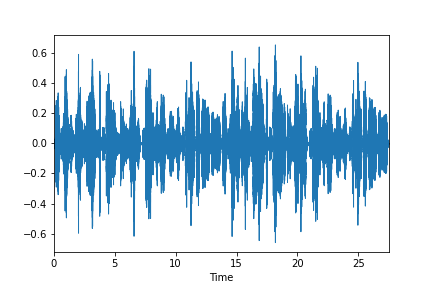

In [5]:
#filename = 'sounds/92bpm_hiphop10secloop.wav'
songId = 1 # First is zero.
filename= "sounds/" + l[songId][0] # Note. change the \ to / if using mac
print(filename)

y_full, sr = librosa.load(filename)
# trim silent edges
y, _ = librosa.effects.trim(y_full)
length = librosa.get_duration(y)
print(f'length of song: {length:.1f} seconds')
y_harmonic, y_percussive = librosa.effects.hpss(y) # Splits the sample into an harmonic and percussive part
librosa.display.waveplot(y_percussive, sr=sr); # Displays a simple waveplot over the percussive part
n_fft = 2048
D = np.abs(librosa.stft(y_percussive[:n_fft], n_fft=n_fft, hop_length=n_fft+1)) #Calculate fast fourier transform


In [6]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)


onset_env = librosa.onset.onset_strength(y_percussive, sr=sr)

static_tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
#static_tempo = librosa.beat.tempo(y,sr=sr, start_bpm=120, std_bpm = 100)[0]
#print(static_tempo)

dynamic_tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)
beats_in_t = librosa.frames_to_time(beats, sr=sr)
#print(beats_in_t)
#print(dynamic_tempo)
actual_tempo = l[songId][-1]
diff = min(abs(int(dynamic_tempo)-int(actual_tempo)), abs(int(static_tempo)-int(actual_tempo)))
#print(diff)
song_name = l[songId][0]
length = librosa.get_duration(y_percussive)
print("""Estimated tempo (dynamic) {0:.1f} BPM, \nEstimated tempo (static): {1:.1f} BPM, \n
Real tempo: {2} BPM. \nMinimum difference {3} BPM \nIn song {4} of length {5:.1f} seconds""".format(dynamic_tempo, static_tempo, actual_tempo, diff, song_name, length))
    


Estimated tempo (dynamic) 136.0 BPM, 
Estimated tempo (static): 129.2 BPM, 

Real tempo: 140 BPM. 
Minimum difference 5 BPM 
In song 140bpm-gassin.wav of length 27.5 seconds


<IPython.core.display.Javascript object>


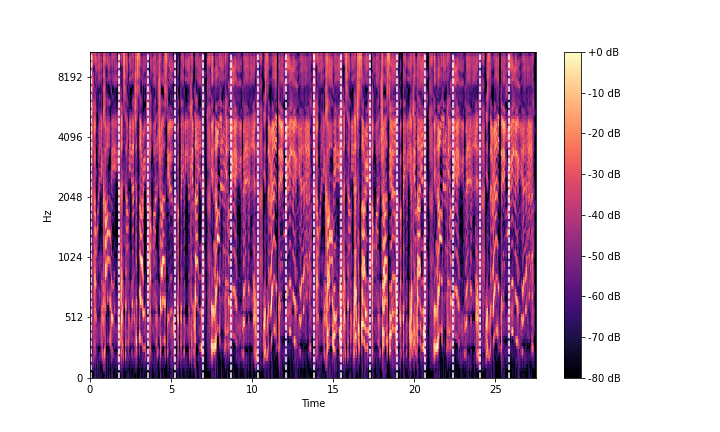

In [7]:
hop_length = 512
S = librosa.feature.melspectrogram(y_percussive, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)


#Display Mel-spectogram with white vertical lines to mark the beats
fig = plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
for xc in beats_in_t[::4]:
    plt.axvline(x=xc, color = "white", linestyle="--")

#Listen to the track with clicks on the beats
y_beat_times = librosa.clicks(frames=beats, sr=sr, length=len(y_percussive))
y_new = y_harmonic+y_percussive+y_beat_times
Audio(data=y_new, rate=sr)

In [8]:
y_tritone = librosa.effects.pitch_shift(y, sr, n_steps=3)
Audio(data=y_tritone, rate=sr)

In [9]:
#Speed it up -- Challenge?
speed_factor = 1.7
y_speed = librosa.effects.time_stretch(y_new, speed_factor)
Audio(data=y_speed, rate=sr)


In [11]:
#To find harmonic features
f0, voiced_flag, voiced_probs = librosa.pyin(y_harmonic+y_percussive, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

times = librosa.times_like(f0)

<IPython.core.display.Javascript object>


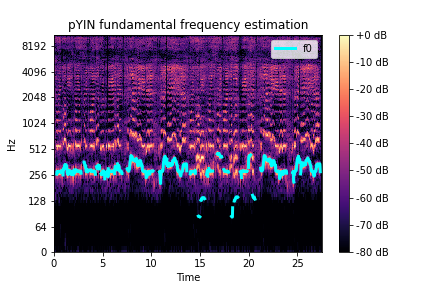

In [12]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_harmonic)), ref=np.max)

fig, ax = plt.subplots()

img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)

ax.set(title='pYIN fundamental frequency estimation')

fig.colorbar(img, ax=ax, format="%+2.f dB")

ax.plot(times, f0, label='f0', color='cyan', linewidth=3)

ax.legend(loc='upper right')



In [23]:
f_clean = f0[~np.isnan(f0)]
f_median = np.median(f_clean)
print(f_clean[:5])
print(f_median)
print('fundamental note: ' + librosa.hz_to_note(f_median))
tone = librosa.tone(f_median, length=len(y_new))
y_n = y_new+tone
print("\nSample + click from estimated bpm + tone from estimated key")
Audio(data=y_n, rate=sr)

[263.14114678 282.02769802 282.02769802 282.02769802 275.5861765 ]
286.9574553484241
fundamental note: D4

Sample + click from estimated bpm + tone from estimated key


<IPython.core.display.Javascript object>


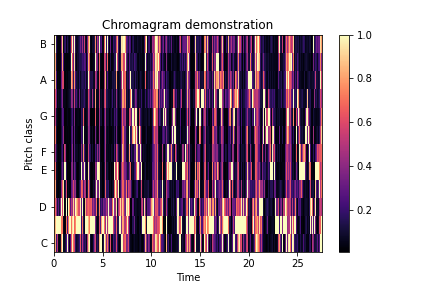

In [16]:
#Food for a CNN-VAE?
chroma = librosa.feature.chroma_cqt(y=y_percussive+y_harmonic, sr=sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)


In [20]:
print(chroma.shape)
d = {0 : "C", 1: "C#", 2: "D", 3: "D#", 4: "E", 5: "F", 6: "F#", 7: "G", 8: "G#", 9: "A", 10: "A#", 11: "B"}
key = np.argmax(np.mean(chroma, axis=1))

included_notes = [d.get(ind) for ind in list(np.where(np.mean(chroma, axis=1) > np.mean(np.mean(chroma, axis=1)))[0])]

print(d.get(key))
norm = np.array([(d.get(i),np.mean(chroma, axis=1)[i]) for i in range(12)])#[(d.get(np.argslrt())) for enumeratenp.mean(chroma, axis=1)

key_ind = np.argsort(np.mean(chroma, axis=1))
print("These are the main tones used in the sample (ordered by weight, first one is likely the key)")
print(norm[key_ind][::-1])


(12, 1186)
C#
These are the main tones used in the sample (ordered by weight, first one is likely the key)
[['C#' '0.57277894']
 ['D' '0.4304826']
 ['C' '0.34191212']
 ['E' '0.33765355']
 ['B' '0.31692237']
 ['G#' '0.30633298']
 ['D#' '0.28545088']
 ['A' '0.2765116']
 ['G' '0.26855925']
 ['A#' '0.2655371']
 ['F#' '0.26041418']
 ['F' '0.26002237']]
